In [1]:
from comet_ml import Experiment
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# print("GPUs disponibles:", gpus)


In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# !git clone https://github.com/emiliodelgadouy/utils.git

In [3]:
from matplotlib import pyplot as plt
from utils.PatchSequence import PatchSequence
from utils.Dataset import Dataset

2025-08-07 08:03:04.155977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754564584.167129  347867 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754564584.170745  347867 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754564584.180706  347867 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754564584.180717  347867 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754564584.180718  347867 computation_placer.cc:177] computation placer alr

In [4]:
dataset = Dataset(lateralize=False, reduced=True, n=10000)

In [6]:
# from google.colab import auth
# auth.authenticate_user()
# !sudo pip install --no-cache-dir -U crcmod
# !gsutil cp gs://helen-data/dumps/dump_cache_reduced_half.npz ./

In [5]:
dataset.load_dump('dump_cache_reduced_half.npz')

In [6]:
ds_training = dataset[(dataset["split"] == "training")&(dataset["view"] == "MLO")]
ds_test = dataset[(dataset["split"] == "test")&(dataset["view"] == "MLO")]

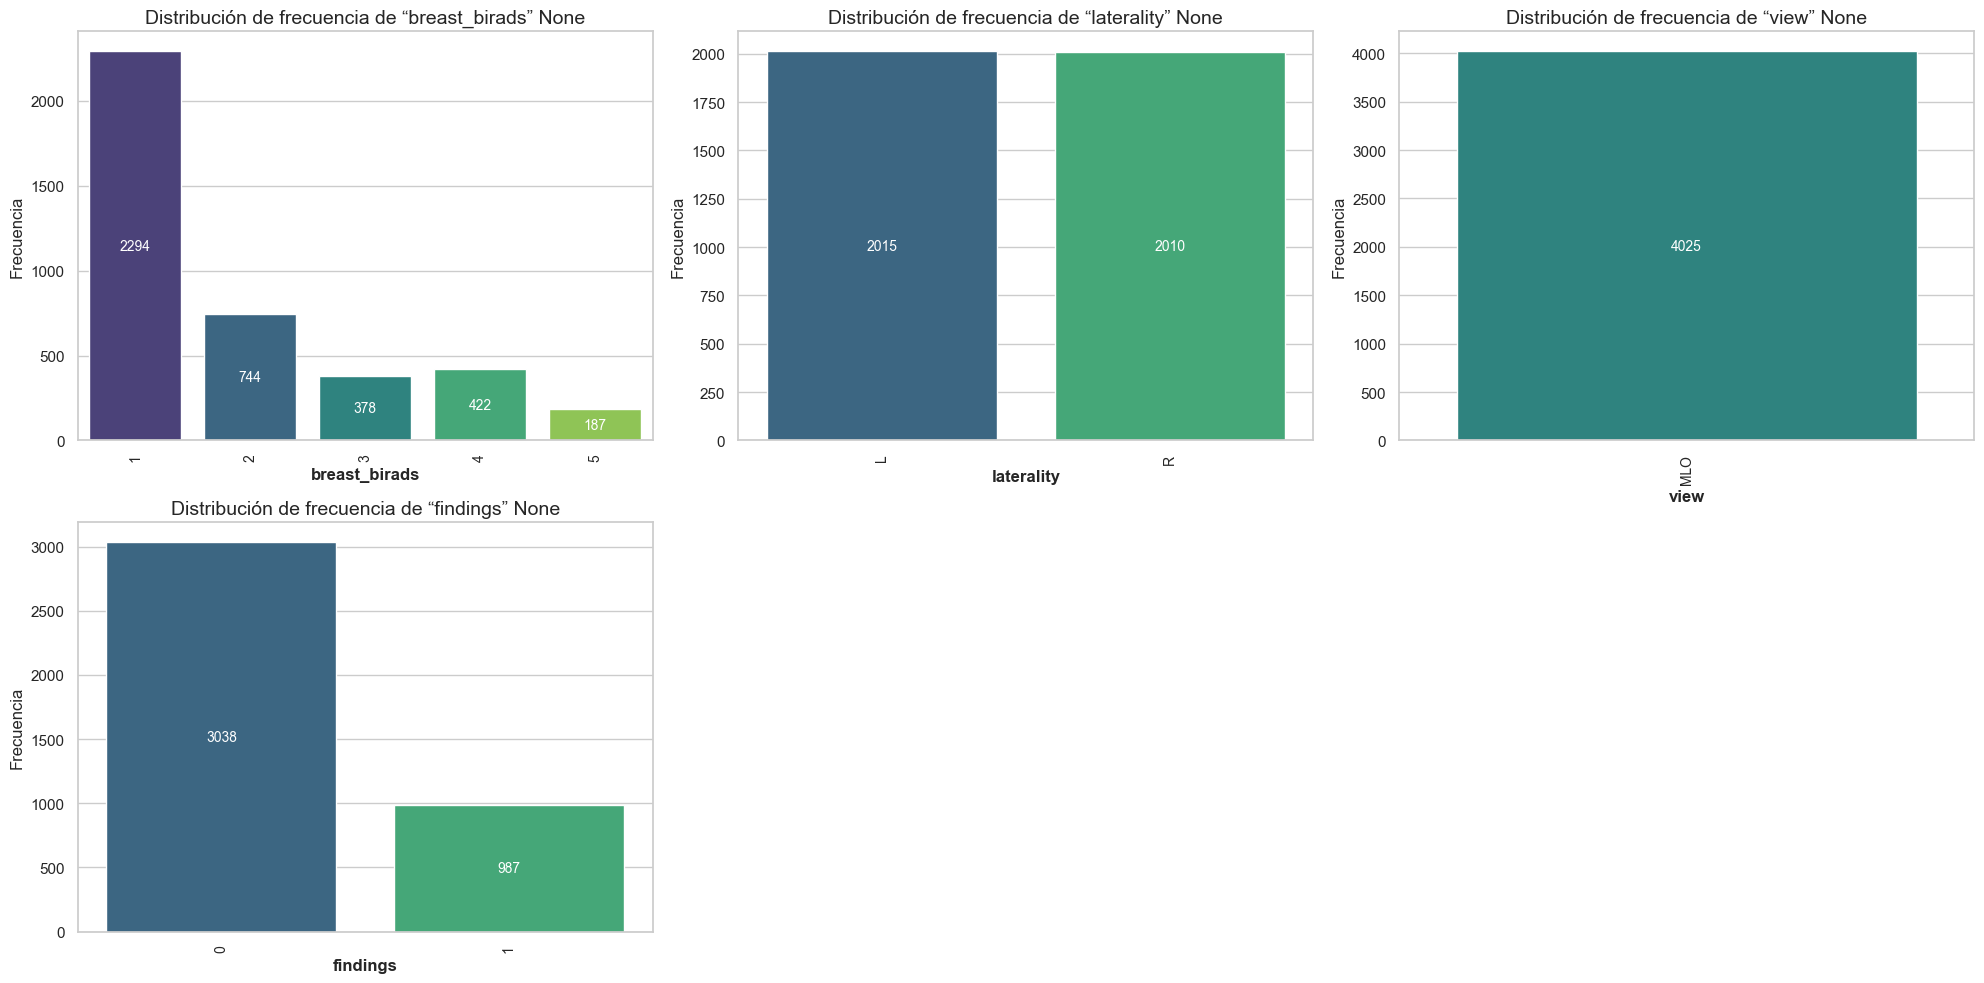

In [7]:
ds_training.stats()

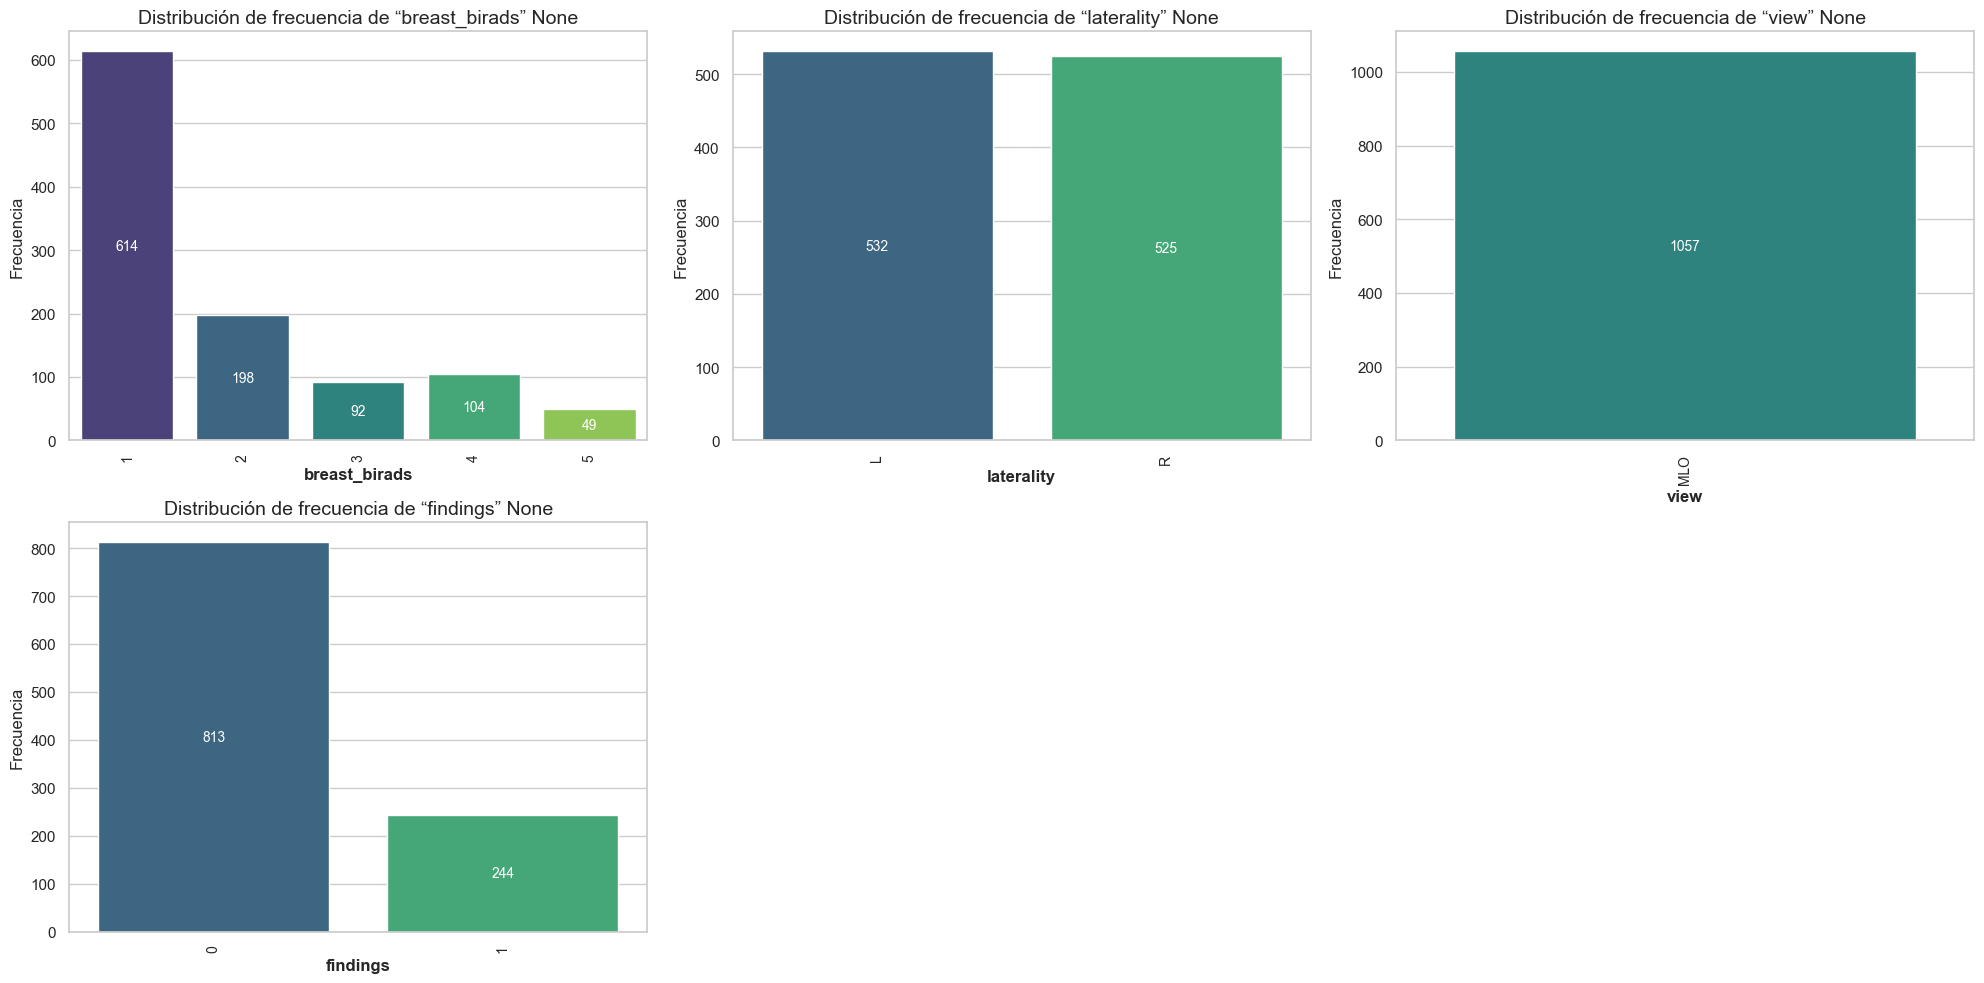

In [8]:
ds_test.stats()

In [11]:
import gc
import optuna
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Crear experimento en Comet
    experiment = Experiment(
        api_key="W8IluWhLfvXgLr8ggg1bwZKTf",
        project_name="analisis",
        workspace="emiliodelgadouy",
        auto_output_logging="simple",
        log_code=False
    )
    experiment.set_name(f"trial_cw_view_{trial.number}")

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pct = trial.suggest_float("unfreeze_pct", 0.0, 0.2)

    IMG_SIZE = (299, 299)
    BATCH_SIZE = 32
    EPOCHS = 40

    experiment.log_parameters({
        "learning_rate": learning_rate,
        "dropout_rate": dropout_rate,
        "l2_reg": l2_reg,
        "backbone": "InceptionV3",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })
    import random
    random.seed(42)
    import tensorflow as tf
    tf.random.set_seed(42)
    train_generator = PatchSequence(
        ds_training,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=True,
        preprocess_fn=preprocess_input
    )
    val_generator = PatchSequence(
        ds_test,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=False,
        preprocess_fn=preprocess_input
    )

    # Backbone
    base = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    for layer in base.layers:
        layer.trainable = False
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)

    if n_unfreeze > 0:
        for layer in base.layers[-n_unfreeze:]:
            layer.trainable = True

    labels = np.array(ds_training["findings"])

    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = {i: w for i, w in enumerate(weights)}
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        512,
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-4, l2=l2_reg)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc_roc', curve='ROC')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc_roc',      # métrica a vigilar
        mode='max',                 # porque queremos maximizar AUC
        patience=10,                 # cuántas épocas sin mejora tolera
        restore_best_weights=True   # vuelve a los pesos de la mejor época
    )
    t0 = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        class_weight=class_weights,
        callbacks=[early_stop],
        verbose=1
    )
    elapsed = time.time() - t0

    experiment.log_metric("training_time_sec", elapsed)
    experiment.log_parameter("unfreeze_pct", unfreeze_pct)


    summary = f"""
    Trial #{trial.number}
    learning_rate: {learning_rate}
    dropout_rate: {dropout_rate}
    l2_reg: {l2_reg}
    unfreeze_pct: {unfreeze_pct}
    """
    experiment.log_other("trial_summary", summary)

    score = model.evaluate(val_generator, steps=len(val_generator), verbose=0)
    experiment.log_metric("final_val_loss",    score[0])
    experiment.log_metric("final_val_accuracy",score[1])
    experiment.log_metric("final_val_auc_roc", score[2])
    experiment.end()
    del model
    del train_generator
    del val_generator
    tf.keras.backend.clear_session()
    gc.collect()
    return score[2]

In [ ]:
study = optuna.create_study(direction='maximize', study_name='optuna_inception')
study.optimize(objective, n_trials=10)

print("🔍 Mejor trial:")
print("  AUC ROC:", study.best_value)
print("  Hiperparámetros:", study.best_params)

[I 2025-08-07 08:05:02,960] A new study created in memory with name: optuna_inception
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/emiliodelgadouy/analisis/8c7b3b7ed2184309b701083395db975d

I0000 00:00:1754564708.088808  347867 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10011 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/40
